feature importance auf modell ohne feature engineering


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )

In [3]:
df = pd.read_parquet("DSCB310 - UE2 - Shopping Carts.parquet")

In [4]:
df = df.reset_index(drop= True)
df = df.fillna(0)

In [5]:
df_sample = df.sample(frac= 0.1)

In [17]:
df_tip = df_sample.groupby(["user_id", "order_id", "order_number"], as_index= False).agg(tip = ("tip", "mean")).sort_values(by= ["user_id", "order_number"], ascending= True)
df_tip["tip_cumsum"] = df_tip.groupby("user_id", as_index= False)["tip"].cumsum()
df_tip["user_tip_ratio"] = df_tip.tip_cumsum / df_tip.order_number

df_tip_merge = df_tip[["user_id", "order_id", "order_number", "user_tip_ratio"]]
df_sample = df_sample.merge(df_tip_merge, on = ["user_id", "order_id", "order_number"], how= "right")

In [6]:
df_classifier = df_sample.copy()

In [7]:
df_classifier = pd.get_dummies(df_classifier, columns= ["county"])

In [8]:
df_classifier

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,tip,...,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba
5863555,580393,38772,8,0,69665,3,5,7,30.0,0,...,0,0,0,0,0,0,0,1,0,0
1086931,107526,21614,8,1,153491,14,2,14,8.0,1,...,0,0,0,0,0,0,0,1,0,0
4288610,424405,33568,8,1,182332,13,6,9,7.0,0,...,0,0,0,0,0,0,0,0,0,0
2117404,209670,2326,4,0,193584,1,3,10,0.0,1,...,0,0,0,0,0,0,0,0,0,0
3848263,380764,10794,34,0,192073,4,5,0,10.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178836,314216,27086,3,1,75979,9,0,12,14.0,0,...,0,0,0,0,0,0,0,0,0,0
4772363,472288,44471,6,1,158869,18,1,9,2.0,1,...,0,0,0,0,0,0,0,0,0,0
210715,20844,1408,19,1,198872,3,0,9,30.0,1,...,0,0,0,0,0,0,0,0,0,0
4728493,467985,6150,11,0,2415,3,6,22,7.0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = df_classifier.drop(["product_name", "department", "aisle", "tip"], axis= 1)
y = df_classifier["tip"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

#### **HGBC**

In [11]:
gs_crss_hgbc = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5,9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_hgbc.best_params_} with acc: {gs_crss_hgbc.best_score_}")

Best param: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'random_state': 0} with acc: 0.6352012738010956


In [12]:
best_hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, max_iter= 100, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_hgbc.predict(X_train)
y_best_test_pred = best_hgbc.predict(X_test)

print_evaluation("HGBC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

HGBC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.63496 |        0.47595 |    0.62052 |   490613 |       68
Test      0.63202 |        0.46920 |    0.61693 |   122654 |       68



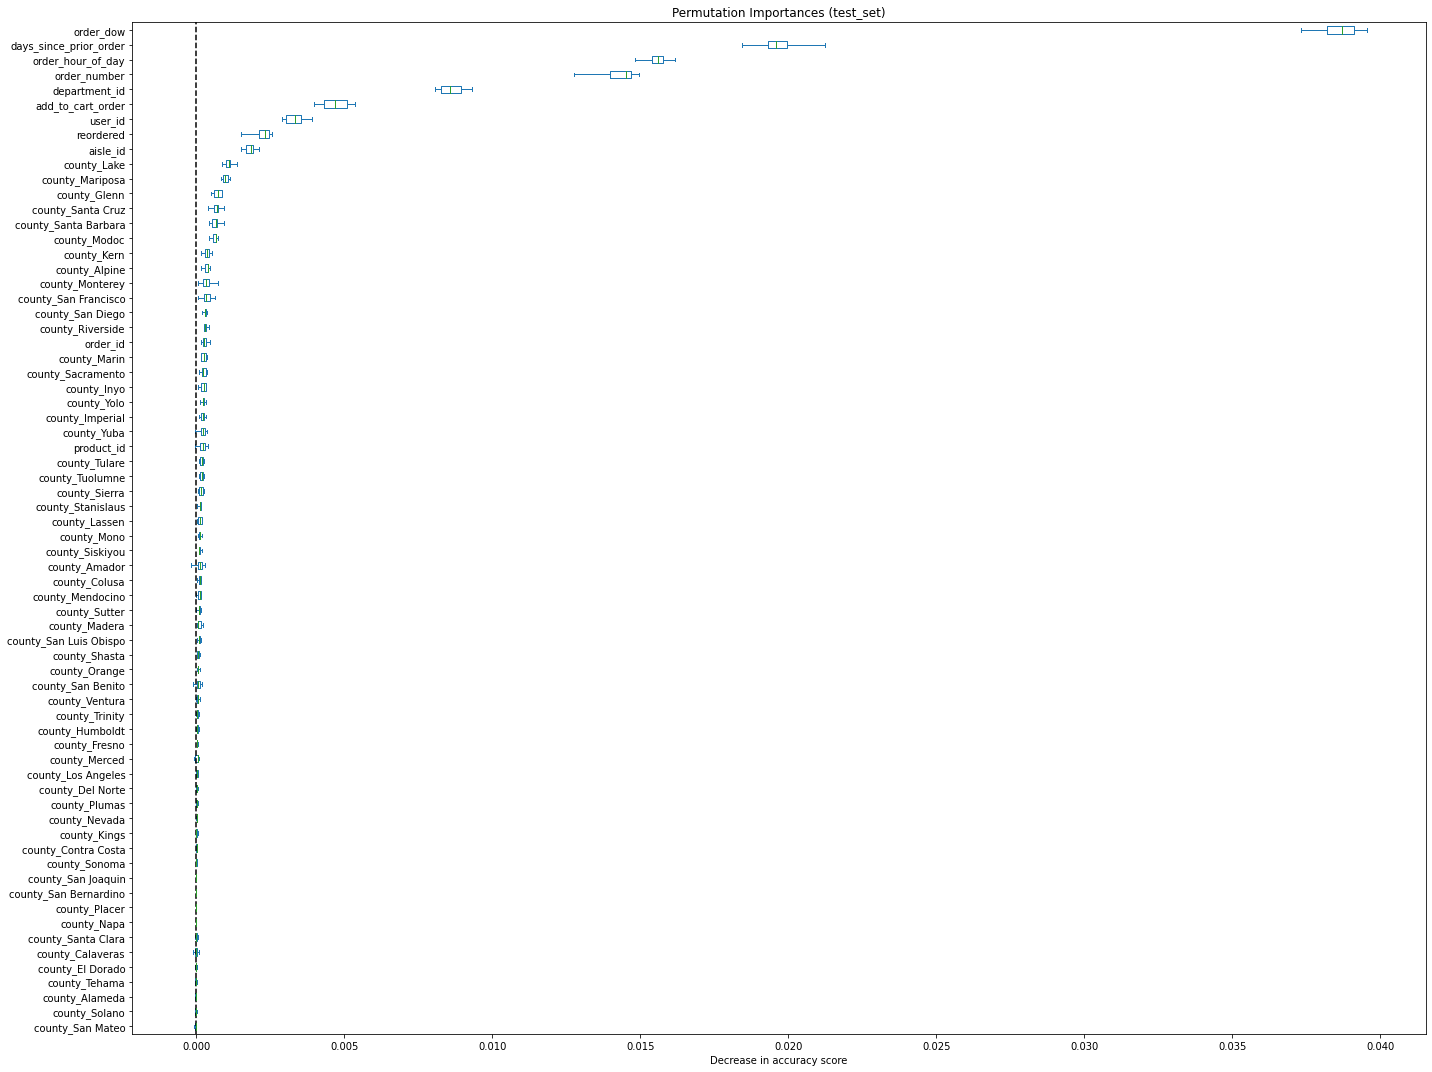

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_hgbc, X_test, y_test, n_repeats= 10, random_state= 0, n_jobs= -1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
 result.importances[sorted_importances_idx].T,
 columns= X.columns[sorted_importances_idx]
)

ax= importances.plot.box(vert= False, whis= 10, figsize= (20, 15))
ax.set_title("Permutation Importances (test_set)")
ax.axvline(x= 0, color= "k", linestyle= "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

#### **DTC**

In [14]:
gs_crss_dtc = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 5, 9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_dtc.best_params_} with acc: {gs_crss_dtc.best_score_}")

Best param: {'max_depth': 9, 'min_samples_split': 2, 'random_state': 0} with acc: 0.6153791267999122


In [15]:
best_dtc = DecisionTreeClassifier(max_depth= 9, min_samples_split= 2, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_dtc.predict(X_train)
y_best_test_pred = best_dtc.predict(X_test)

print_evaluation("DTC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

DTC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.62265 |        0.44900 |    0.60626 |   490613 |       68
Test      0.61832 |        0.44142 |    0.60009 |   122654 |       68



In [16]:
# 'user_tip_ratio': 0.9335026329367192
# 'order_dow': 0.031994586879281556
# 'order_hour_of_day': 0.015698835635160557
print(dict(zip(X.columns, best_dtc.feature_importances_)))

{'order_id': 0.019581176205294853, 'product_id': 0.002537565071532999, 'add_to_cart_order': 0.022761942309562227, 'reordered': 0.006659065878254095, 'user_id': 0.02214895472079787, 'order_number': 0.1447682936353831, 'order_dow': 0.26321289253051317, 'order_hour_of_day': 0.11834175897163453, 'days_since_prior_order': 0.31906231707003263, 'aisle_id': 0.0031052613953845994, 'department_id': 0.04841315012127472, 'county_Alameda': 0.0, 'county_Alpine': 0.002244993863614482, 'county_Amador': 0.0, 'county_Calaveras': 0.0015117222700695514, 'county_Colusa': 0.0, 'county_Contra Costa': 0.0007651771762174871, 'county_Del Norte': 0.0, 'county_El Dorado': 0.0, 'county_Fresno': 0.000432596391538689, 'county_Glenn': 0.0023329571095769734, 'county_Humboldt': 0.0, 'county_Imperial': 0.0008681458648554431, 'county_Inyo': 0.00020955951935235583, 'county_Kern': 0.0004655911828492815, 'county_Kings': 0.0, 'county_Lake': 0.002773278902561399, 'county_Lassen': 0.0006038669201519709, 'county_Los Angeles': 0